# Анализ оттока клиентов банка

# Содержание

Часть 1. Описание проекта.<br>

* 1. Описание исследования
* 2. Цель исследования

Часть 2. Предобработка данных.<br>

* 1. Изучение данных
* 2. Обработка типов и наименований колонок
* 3. Обработка пропусков
* 4. Обработка дубликатов

Часть 3. Проведение исследовательского анализа данных (EDA).<br>

* 1. Категоризация клиентов по возрасту и балансу
* 2. Расчет средних значений признаков для групп "Оставшиеся" и "Ушедшие"
* 3. Построение столбчатых гистограмм признаков для групп "Оставшиеся" и "Ушедшие"
* 4. Построение столбчатых гистограмм признаков для разных городов
* 5. Расчет оставшихся/ушедших клиентов для разных возрастных групп
* 6. Расчет оставшихся/ушедших клиентов для разных балансных групп 
* 7. Построение матрицы корреляции

Часть 4. Построение портретов клиентов.<br>

* 1. Стандартизация данных
* 2. Матрица расстояний
* 3. Обучение модели
* 4. Оценка доли оттока в разных кластерах 

Часть 5. Проверка статистических гипотез.<br>

* 1. Проверка гипотезы различия дохода между теми клиентами, которые ушли и теми, которые остались
* 2. Проверка гипотезы различия баланса между теми клиентами, которые ушли и теми, которые остались

Часть 6. Выводы.<br>

* 1. Общий вывод по работе


## Часть. Описание проекта
### Описание проекта

В нашем распоряжении данные о клиентах банка "Метанпром", который располагается в Ярославле, Ростове Великом и Рыбинске. Необходимо проанализировать предложенные данные и выявить клиентов, которые склонны уходить из банка.

Состав данных:

- `userid` — идентификатор пользователя
- `score` — баллы кредитного скоринга
- `City` — город
- `Gender` — пол
- `Age` — возраст
- `Objects` — количество объектов в собственности
- `Balance` — баланс на счёте
- `Products` — количество продуктов, которыми пользуется клиент
- `CreditCard` — есть ли кредитная карта
- `Loyalty` — активный клиент
- `estimated_salary` — заработная плата клиента
- `Churn` — ушёл или нет

### Цели проекта
1. Выделить портреты клиентов, склонных уходить из банка.
2. Проверить статистические гипотезы:<br>
"Различия между доходом ушедших и оставшихся клиентов нет"<br>
"Различия между балансами ушедших и оставшихся клиентов нет"

## Часть. Предобработка данных
### Изучение данных

In [1]:
# Подключение библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats as st
from sklearn.cluster import KMeans

pd.options.mode.chained_assignment = None

pd.set_option('display.float_format', '{:.4f}'.format)

In [2]:
# Чтение файла с данными
bank_data = pd.read_csv('/datasets/bank_dataset.csv')

In [3]:
# Функция для вывода основных данных по датасету
def all_info(data):
    print('Общая информация')
    data.info() #вывод общей информации
    display('Первые значения', data.head(5)) #вывод первых 10 значений
    display('Описание данных', data.describe()) #вывод описательной статистики по датасету
    display('Дубликаты', data.duplicated().sum()) #поиск явных дубликатов в данных
    display('Пропуски', data.isna().mean().apply('{:.2%}'.format)) #подсчет пропусков в датасете в %
    print('*'*50)
    
# Применение функции к данным
all_info(bank_data)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


'Первые значения'

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.8800,1
1,15690047,608,Рыбинск,Ж,41,1,83807.8600,1,0,1,112542.5800,0
2,15662040,502,Ярославль,Ж,42,8,159660.8000,3,1,0,113931.5700,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.6300,0
4,15780624,850,Рыбинск,Ж,43,2,125510.8200,1,1,1,79084.1000,0


'Описание данных'

,userid,score,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
count,10000.0000,10000.0000,10000.0000,10000.0000,6383.0000,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000
mean,15733676.5694,650.5288,38.9218,5.0128,119827.4938,1.5302,0.7055,0.5151,100090.2399,0.2037
std,71936.1861,96.6533,10.4878,2.8922,30095.0565,0.5817,0.4558,0.4998,57510.4928,0.4028
min,15608437.0000,350.0000,18.0000,0.0000,3768.6900,1.0000,0.0000,0.0000,11.5800,0.0000
25%,15671264.2500,584.0000,32.0000,3.0000,100181.9750,1.0000,0.0000,0.0000,51002.1100,0.0000
50%,15733474.0000,652.0000,37.0000,5.0000,119839.6900,1.0000,1.0000,1.0000,100193.9150,0.0000
75%,15795969.7500,718.0000,44.0000,7.0000,139512.2900,2.0000,1.0000,1.0000,149388.2475,0.0000
max,15858426.0000,850.0000,92.0000,10.0000,250898.0900,4.0000,1.0000,1.0000,199992.4800,1.0000


'Дубликаты'

0

'Пропуски'

userid               0.00%
score                0.00%
City                 0.00%
Gender               0.00%
Age                  0.00%
Objects              0.00%
Balance             36.17%
Products             0.00%
CreditCard           0.00%
Loyalty              0.00%
estimated_salary     0.00%
Churn                0.00%
dtype: object

**************************************************


Предоставленные данные состоят из 10000 строк и 12 колонок. В данных отсутствуют явные дубликаты, при этом есть пропуски в колонке `Balance`, на которые следует обратить внимание. Также можно сказать, что типы данных колонок соответствуют их содержимому, при этом для удобства стоит привести наименования колонок к нижнему регистру.<br>

### Обработка типов и наименований колонок

Типы данных соответствуют содержимому, а вот наименования стоит привести к более удобному виду

In [4]:
# Приведение наимменований к нижнему регистру
bank_data.columns = bank_data.columns.str.lower()
# Наименования некоторых колонок написаны слитно, стоит их разделить
bank_data = bank_data.rename(columns={'userid': 'user_id', 'creditcard': 'credit_card'})
# Проверка результата
bank_data.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'credit_card', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

### Обработка пропусков

Пропуски присутствуют в колонке `balance` и составляют 36% данных, это довольно большой процент данных. Проверим насколько он коррелирует с другими признаками.

In [5]:
# Проверка корреляции баланса с другими признаками
corr = bank_data.corr()
corr['balance'].drop('balance')

user_id            -0.0087
score              -0.0047
age                -0.0128
objects             0.0058
products           -0.0010
credit_card         0.0067
loyalty            -0.0204
estimated_salary   -0.0019
churn               0.0172
Name: balance, dtype: float64

Признак `balance` не коррелирует с другими признаками, поэтому заполнять пропуски, опираясь на связь баланса с другими признаками нет смысла. Можно заполнить данные медианными значениями, но получится следующий результат при построении графиков:

![balance](balance.jpg)

Стоит оставить пропуски в колонке `balance` неизменными, т.к. сложно спрогнозировать, какой баланс у кого должен быть, связывая этот признак с другими, а простая замена на среднее или медианное значение выглядит как аномалия или выброс.

### Обработка дубликатов

В данных нет явных дубликатов, но возможно есть неявные, стоит проверить уникальные значения в колонке `city`

In [6]:
bank_data['city'].unique()

array(['Ярославль', 'Рыбинск', 'Ростов Великий'], dtype=object)

В предоствавленных данных отсутствуют дубликаты

**Выводы**

В предложенном датасете 10000 строк и 4 колонки, среди них обнаружены пропуски в колонке `balance`, дубликатов в данных нет, типы данных колонок соответствуют содержимому, наименования колонок приведены в удобный для работы вид.<br>
На основании описательной статистики можно сделать некоторые выводы о клиентах банка, например: 50% клиентов не старше 37 лет, 75% клиентов используют не более 2 банковских услуг, а баланс не превышает 140000.

## Часть. Проведение исследовательского анализа данных (EDA)
### Категоризация клиентов по возрасту и балансу

В данных есть колонки, которые можно категоризировать, в данной работе на категории разбиваются колонки `age` и `balance`. Возраст можно разделить на "молодой", "средний", "пожилой", а баланс на "низкий", "средний" и "высокий".

In [7]:
# Функция для присвоения возрастной категории
def age(elem):
    if elem < 35:
        return 'молодой'
    if 35 <= elem < 60:
        return 'средний'
    if 60 <= elem:
        return 'пожилой'
# Создание дополнительной колонки с возрастной категорией
bank_data['age_group'] = bank_data['age'].apply(age)

In [8]:
# Функция для присвоения категории на основе баланса
def balance(elem):
    if elem < 90000:
        return 'низкий'
    if 90000 <= elem < 150000:
        return 'средний'
    if 150000 <= elem:
        return 'высокий'
    else:
        return 'нет данных'
# Создание дополнительной колонки с балансной категорией
bank_data['balance_group'] = bank_data['balance'].apply(balance)

In [9]:
# Проверка результата
bank_data.head(5)

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,age_group,balance_group
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.8800,1,средний,нет данных
1,15690047,608,Рыбинск,Ж,41,1,83807.8600,1,0,1,112542.5800,0,средний,низкий
2,15662040,502,Ярославль,Ж,42,8,159660.8000,3,1,0,113931.5700,1,средний,высокий
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.6300,0,средний,нет данных
4,15780624,850,Рыбинск,Ж,43,2,125510.8200,1,1,1,79084.1000,0,средний,средний


### Расчет средних значений признаков для групп "Оставшиеся" и "Ушедшие"

Сгруппируем клиентов по 2 группами "Оставшиеся" и "Ушедшие" и сравним средние значения каждого признака в обеих группах

In [10]:
# Рассчет средних значений в группах в зависимости от оттока
bank_data.groupby('churn', as_index=False).mean().T.rename(columns={0: 'Оставшиеся', 1: 'Ушедшие'})

,Оставшиеся,Ушедшие
churn,0.0000,1.0000
user_id,15733903.8817,15732787.9647
score,651.8532,645.3515
age,37.4084,44.8380
objects,5.0333,4.9327
balance,119535.8643,120746.9711
products,1.5443,1.4752
credit_card,0.7071,0.6991
loyalty,0.5546,0.3608
estimated_salary,99738.3918,101465.6775


По полученным средним значениям можно сказать следующее:

1) Средний возраст ушедших клиентов банка - 45 лет, оставшихся - 37<br>
2) Ушедшие клиенты менее активно пользовались банковскими продуктами, в отличии от оставшихся

По остальным показателям обе группы схожи

### Построение столбчатых гистограмм признаков для групп "Оставшиеся" и "Ушедшие"

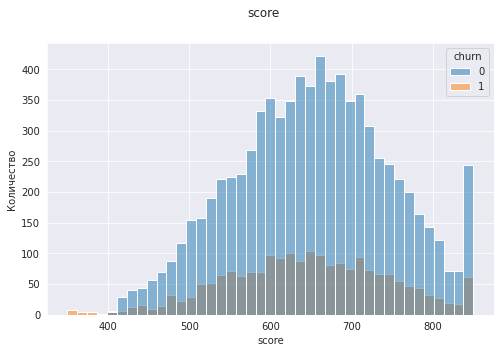

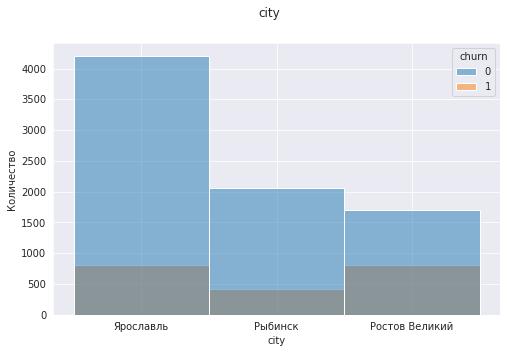

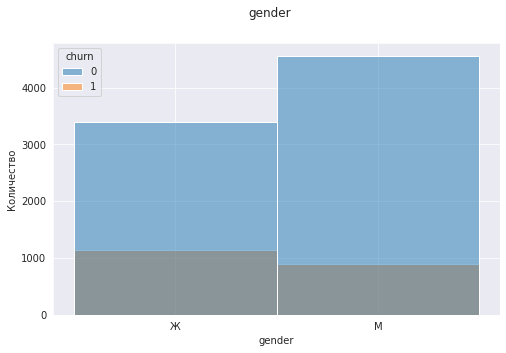

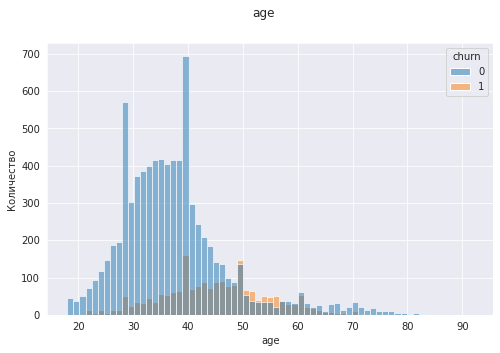

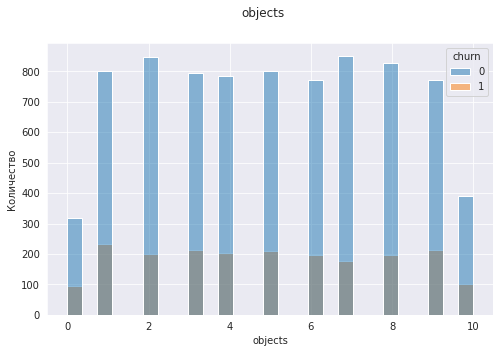

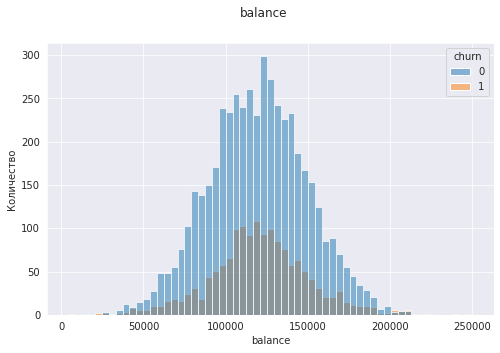

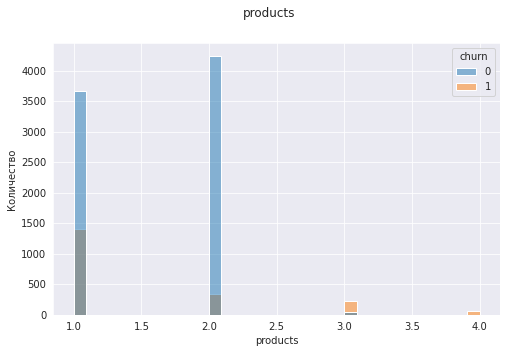

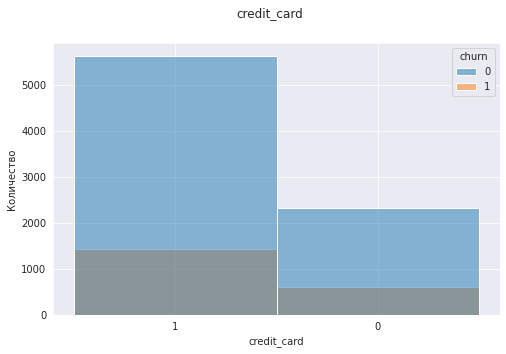

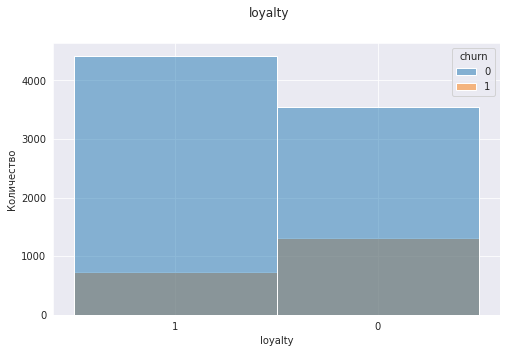

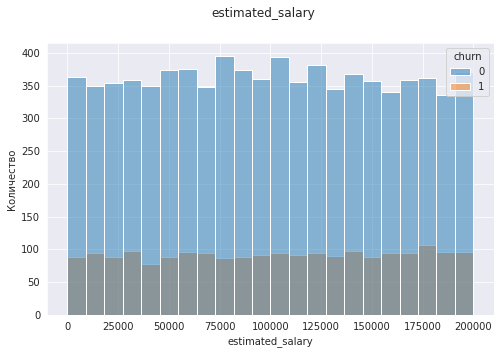

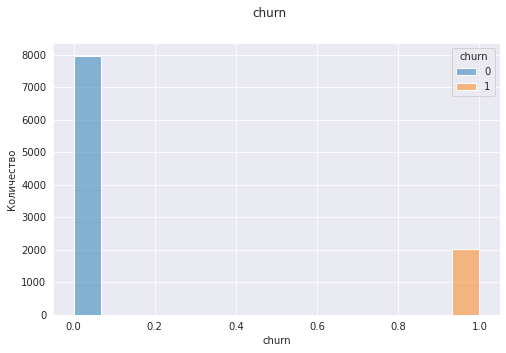

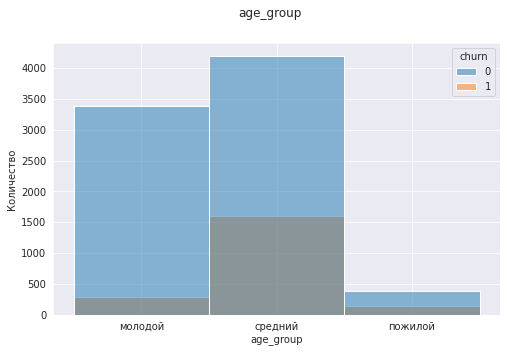

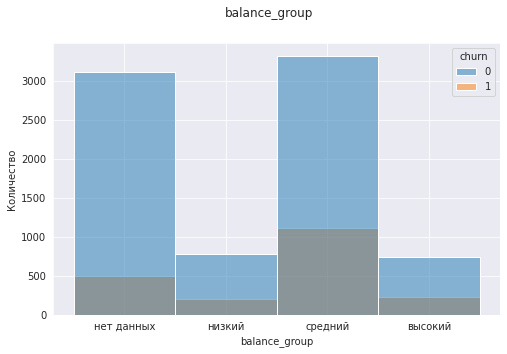

In [11]:
# Построение столбчатых гистограмм признаков оставшихся и ушедших клиентов

# Подготовка данных для построения графиков
graf_data = bank_data.drop(columns=['user_id'])
graf_data['loyalty'] = graf_data['loyalty'].astype('string')
graf_data['credit_card'] = graf_data['credit_card'].astype('string')

# Установка порядка для отображения категориальных признаков
graf_data['balance_group'] = pd.Categorical(graf_data['balance_group'], ['нет данных','низкий','средний','высокий'])
graf_data['age_group'] = pd.Categorical(graf_data['age_group'], ['молодой','средний','пожилой'])

# Настройки графиков
sns.set_style("darkgrid")

# Цикл, который проходит по признакам в таблице
for column in graf_data.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=graf_data, x=column, hue='churn')
    plt.ylabel('Количество')
    plt.suptitle(column)
    plt.show()

Гистограммы подтвердили предположения, сделанные для средних значений, при этом выводы можно дополнить следующими пунктами:
1) Средний возраст ушедших клиентов банка - 45 лет, оставшихся - 37<br>
2) Ушедшие клиенты менее активно пользовались банковскими продуктами, в отличии от оставшихся<br>
3) Отток клиентов в Ростове Великом и в Ярославле почти одинаковый, но в Ярославле больше клиентов в целом и в 2 раза больше оставшихся клиентов, чем в Ростове Великом<br>
4) Большая часть ушедших клиентов это женщины<br>
5) Большая часть ушедших клиентов пользовались 1 продуктом, также клиенты, у которых более 2 продуктов, уходят чаще<br>
6) При рассмотрении возрастных категорий, большую часть среди оставшихся занимает средний возраст, на втором месте молодой, при этом среди ушедших клиентов среднего возраста также много, в отличии от молодых 

Оценим распределение количества клиентов для числовых признаков

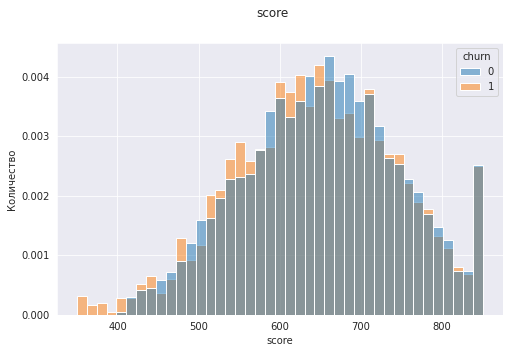

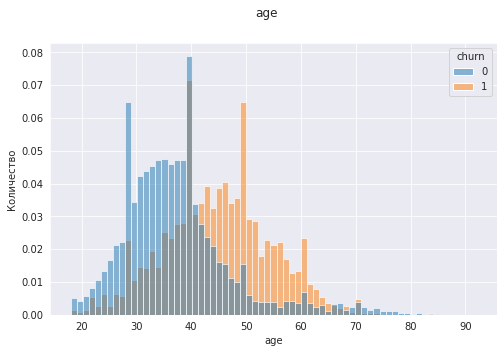

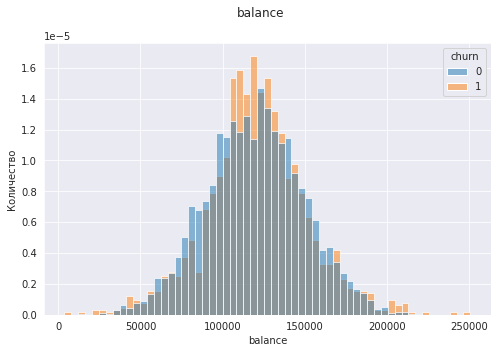

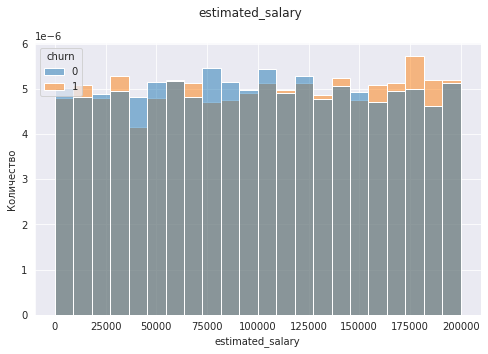

In [12]:
# Для оценки смещения распределения
no_scale = ['score', 'age', 'balance', 'estimated_salary'] 
# Цикл, который проходит по признакам в таблице
for column in no_scale:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=graf_data, x=column, hue='churn', stat='density', common_norm=False)
    plt.ylabel('Количество')
    plt.suptitle(column)
    plt.show()

По распределениям можно сказать следующее:
1) Клиенты с более плохим кредитным рейтингом уходят чаще<br>
2) Клиенты средней и пожилой группы уходят чаще<br>
3) В основном уходят клиенты, которые относятся к средней балансной группе<br>
4) Клиенты с доходом выше ~150 тыс. уходят чаще<br>

### Построение столбчатых гистограмм признаков для разных городов

Рассмотрим распределение признаков в зависимости от города

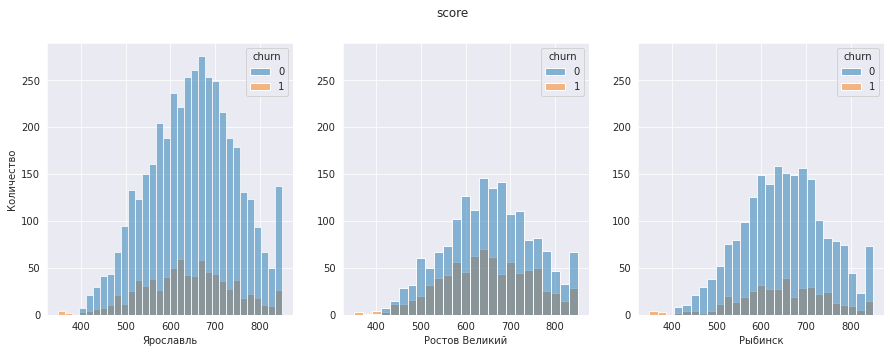

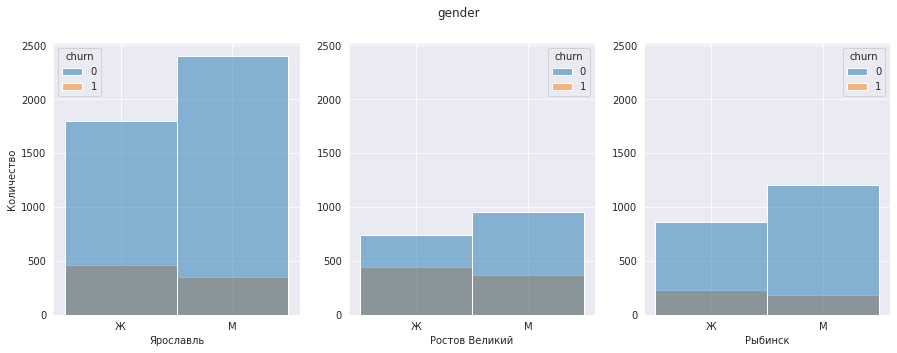

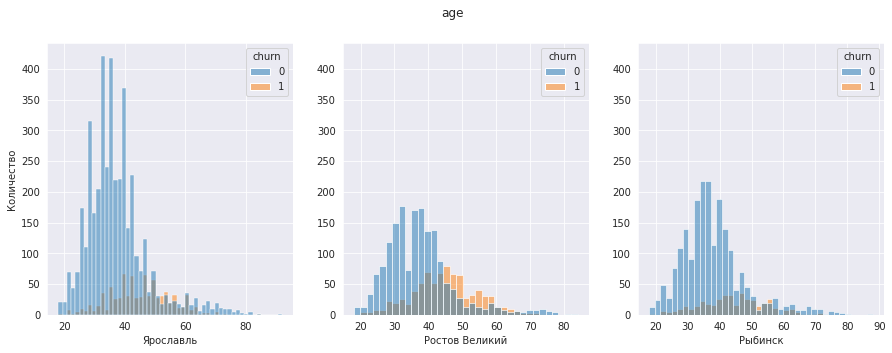

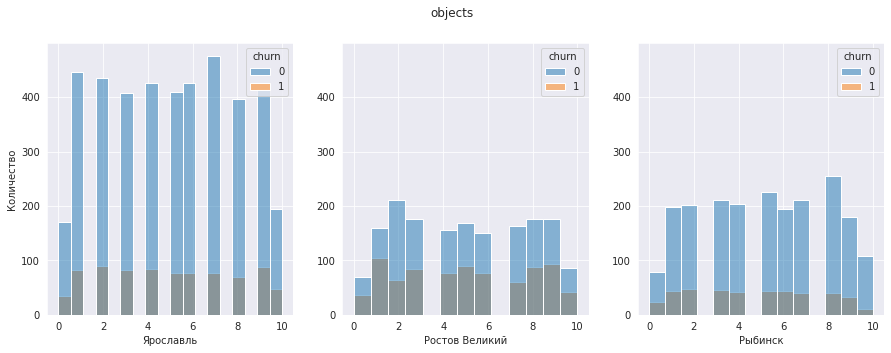

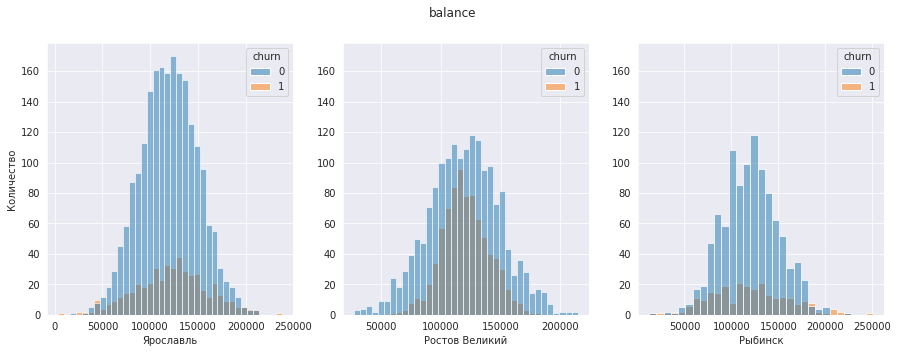

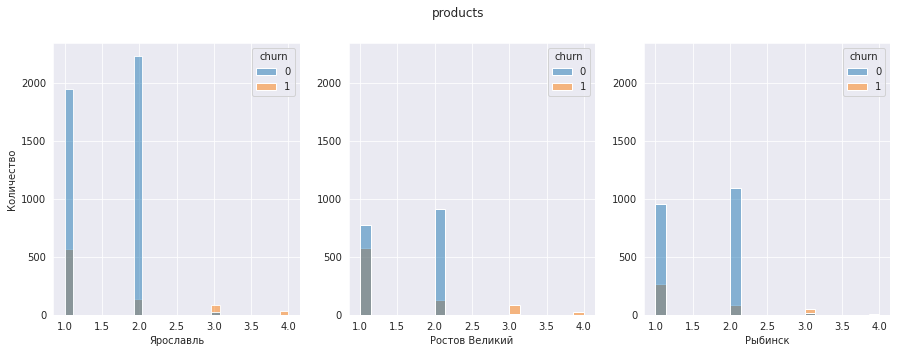

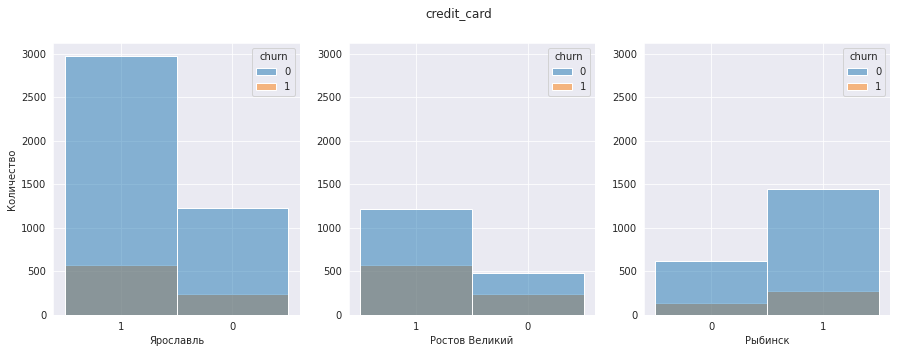

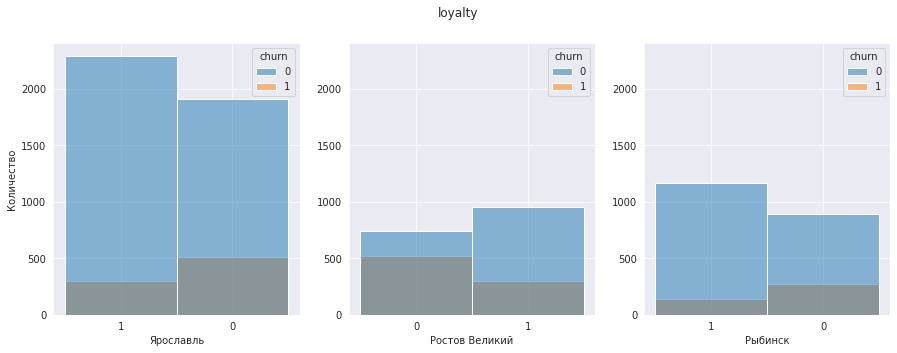

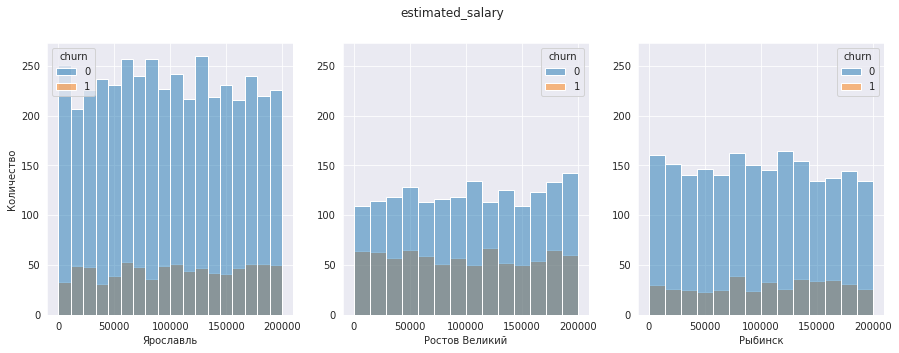

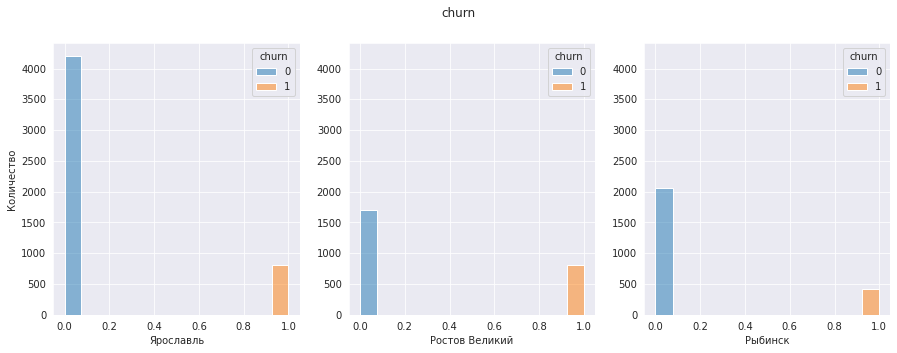

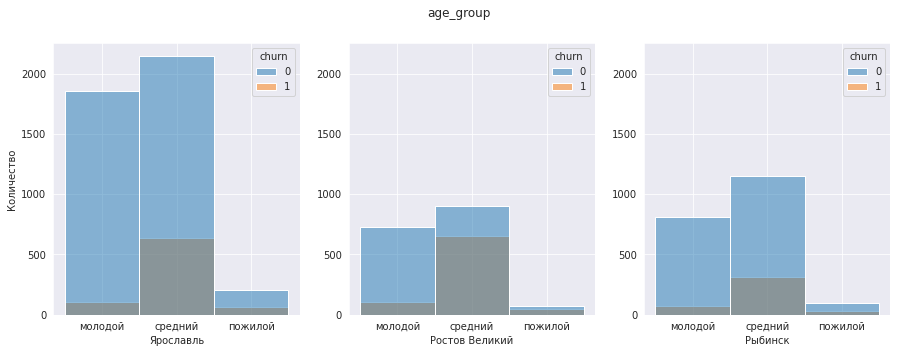

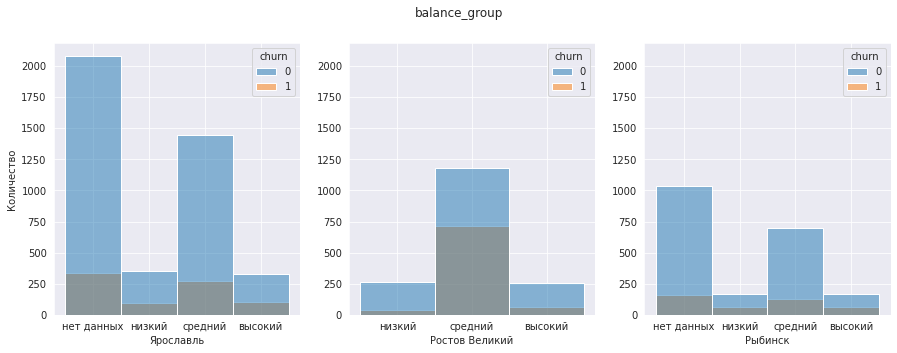

In [13]:
# Построение столбчатых гистограмм признаков оставшихся и ушедших клиетов

# Выделение клиентов из Ярославля
yaroslavl = graf_data.query('city == "Ярославль"')
yaroslavl.drop(columns=['city'], inplace=True)

# Выделение клиентов из Ростова Великого
rostov = graf_data.query('city == "Ростов Великий"')
rostov.drop(columns=['city'], inplace=True)

# Выделение клиентов из Рыбинска
rybinsk = graf_data.query('city == "Рыбинск"')
rybinsk.drop(columns=['city'], inplace=True)

# Настройки графиков
# plt.rcParams['font.size'] = '12'
sns.set_style("darkgrid")

# Цикл, который проходит по признакам в таблице (признаки в 3х таблицах одинаковые)
for column in yaroslavl.columns:
    plt.figure(figsize=(15, 5))
    
    # Гистограмма Ярославля
    ax1 = plt.subplot(1, 3, 1)
    sns.histplot(data=yaroslavl, x=column, hue='churn')
    plt.xlabel('Ярославль')
    plt.ylabel('Количество')
    
    # Гистограмма Ростова Великого
    ax2 = plt.subplot(1, 3, 2, sharey=ax1)
    sns.histplot(data=rostov, x=column, hue='churn')
    plt.xlabel('Ростов Великий')
    plt.ylabel('')
    
    # Гистограмма Рыбинска
    ax3 = plt.subplot(1, 3, 3, sharey=ax1)
    sns.histplot(data=rybinsk, x=column, hue='churn')
    plt.xlabel('Рыбинск')
    plt.ylabel('')
    
    plt.suptitle(column)
    plt.show()

Гистограммы также подтвердили предположения, сделанные в предыдущих пунктах. Отток клиентов в Ростове Великом  в средней и пожилой группе довольно высок

Оценим распределение количества клиентов для числовых признаков

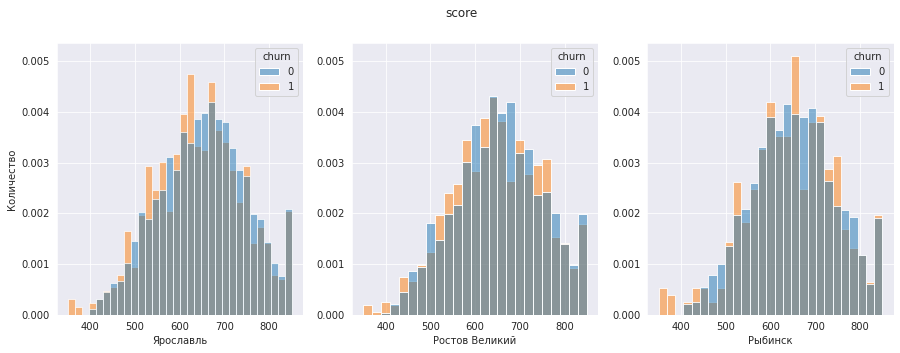

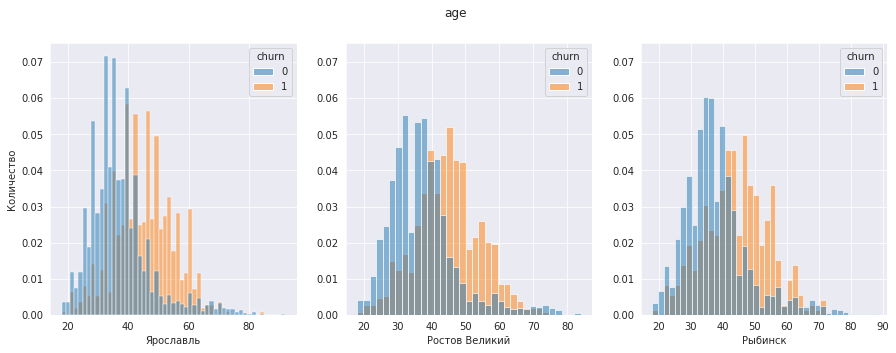

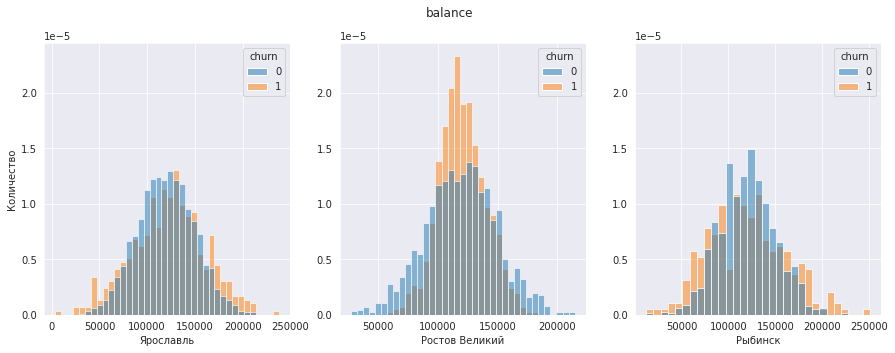

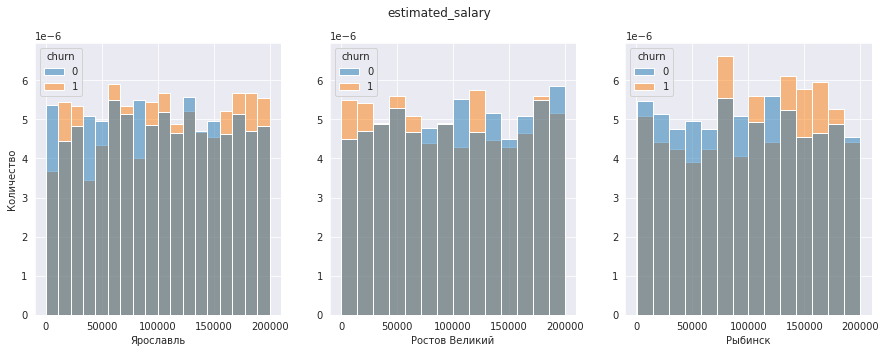

In [14]:
# Для оценки смещения распределения
no_scale = ['score', 'age', 'balance', 'estimated_salary'] 
# Цикл, который проходит по признакам в таблице
for column in no_scale:
    plt.figure(figsize=(15, 5))
    
    # Гистограмма Ярославля
    ax1 = plt.subplot(1, 3, 1)
    sns.histplot(data=yaroslavl, x=column, hue='churn', stat='density', common_norm=False)
    plt.xlabel('Ярославль')
    plt.ylabel('Количество')
    
    # Гистограмма Ростова Великого
    ax2 = plt.subplot(1, 3, 2, sharey=ax1)
    sns.histplot(data=rostov, x=column, hue='churn', stat='density', common_norm=False)
    plt.xlabel('Ростов Великий')
    plt.ylabel('')
    
    # Гистограмма Рыбинска
    ax3 = plt.subplot(1, 3, 3, sharey=ax1)
    sns.histplot(data=rybinsk, x=column, hue='churn', stat='density', common_norm=False)
    plt.xlabel('Рыбинск')
    plt.ylabel('')
    
    plt.suptitle(column)
    plt.show()

По графикам можно сказать следующее:
1) Во всех городах ушедшими клиентами являются средняя и пожилая возрастные группы<br>
2) В Ярославле и Ростове Великом клиенты с более плохим кредитным рейтингом уходят чаще<br>
3) В Ярославле и Рыбинске больший отток клиентов, относящихся к низкой или высокой балансной группе, в Ростове Великом наоборот, больший отток средней балансной группы<br>
4) В Ростове Великом больший отток клиентов, чей доход ниже ~100 тыс., в Рыбинске чей доход больше ~100 тыс., в Ярославле чей доход выше ~150 тыс.<br>

### Расчет оставшихся/ушедших клиентов для разных возрастных групп

In [15]:
# Пустой фрейм под результат
res=pd.DataFrame()

# Цикл расчитывающий оставшихся/ушедших клиентов по возрастным группам
for group in (bank_data['age_group'].unique()):
    age_data = (
        bank_data.query('age_group == @group').groupby(['age_group', 'churn'], as_index=False)['user_id']
        .count().rename(columns={'user_id': 'count'})
    )
    age_data['percent'] = age_data['count'] / age_data['count'].sum() * 100
    res = pd.concat([res, age_data])

# Результат
res['age_group'] = pd.Categorical(res['age_group'], ['молодой','средний','пожилой']) 
display(res.sort_values('age_group').reset_index(drop=True))

,age_group,churn,count,percent
0,молодой,0,3389,92.1174
1,молодой,1,290,7.8826
2,средний,0,4195,72.3900
3,средний,1,1600,27.6100
4,пожилой,0,379,72.0532
5,пожилой,1,147,27.9468


Самый низкий отток клиентов наблюдается у молодой группы - 8%, у средней и пожилой возрастных групп - 28%.

### Расчет оставшихся/ушедших клиентов для разных балансных групп 

In [16]:
# Пустой фрейм под результат
res=pd.DataFrame()

# Цикл расчитывающий оставшихся/ушедших клиентов по возрастным группам
for group in (bank_data['balance_group'].unique()):
    age_data = (
        bank_data.query('balance_group == @group').groupby(['balance_group', 'churn'], as_index=False)['user_id']
        .count().rename(columns={'user_id': 'count'})
    )
    age_data['percent'] = age_data['count'] / age_data['count'].sum() * 100
    res = pd.concat([res, age_data])

# Результат
res['balance_group'] = pd.Categorical(res['balance_group'], ['нет данных','низкий','средний','высокий']) 
display(res.sort_values('balance_group').reset_index(drop=True))

,balance_group,churn,count,percent
0,нет данных,0,3117,86.1764
1,нет данных,1,500,13.8236
2,низкий,0,782,79.3909
3,низкий,1,203,20.6091
4,средний,0,3319,74.9379
5,средний,1,1110,25.0621
6,высокий,0,745,76.8834
7,высокий,1,224,23.1166


Наибольший отток клиентов, у которых от 100000 до 150000 на балансе

### Построение матрицы корреляции

Построим матрицу корреляции, чтобы посмотреть на зависимость признаков друг от друга

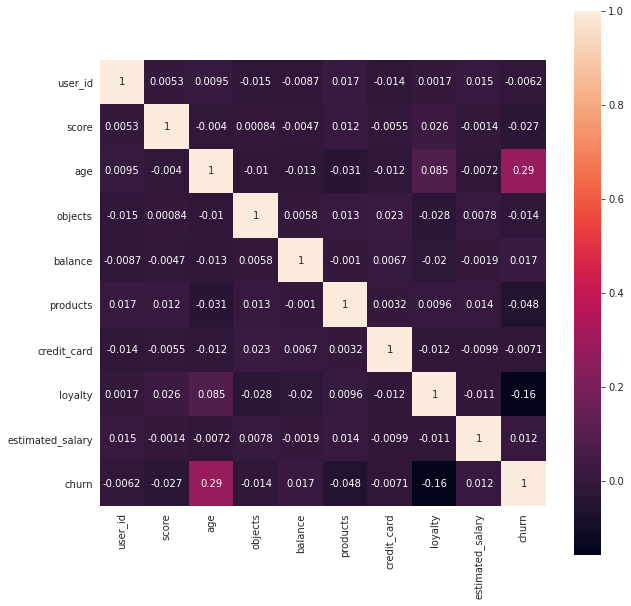

In [17]:
# Построение матрицы корреляции
corr = bank_data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, square=True, annot=True)
plt.show()

Единственные 2 признака, имеющие очень слабую положительную корреляцию, это отток и возраст

**Выводы**

1) Средний возраст ушедших клиентов банка - 45 лет, оставшихся - 37<br>
2) Ушедшие клиенты менее активно пользовались банковскими продуктами, в отличии от оставшихся<br>
3) Отток клиентов в Ростове Великом и в Ярославле почти одинаковый, но в Ярославле больше клиентов в целом и в 2 раза больше оставшихся клиентов, чем в Ростове Великом<br>
4) Большая часть ушедших клиентов это женщины<br>
5) Большая часть ушедших клиентов пользовались 1 продуктом, также клиенты, у которых более 2 продуктов, уходят чаще<br>
6) Самый низкий отток клиентов наблюдается у молодой группы - 8%, у средней и пожилой возростных групп - 28%.
7) Наибольший отток клиентов, у которых от 100000 до 150000 на балансе

Этих данных уже достаточно чтобы выделить портрет ушедших клиентов, дополнительно проведем кластеризацию

In [18]:
# "Ручная кластеризация"
for city in (bank_data['city'].unique()):
    res=pd.DataFrame()
    for a_group in (bank_data['age_group'].unique()):
        age_data = (
            bank_data.query('age_group == @a_group and city == @city')
            .groupby(['city', 'age_group', 'churn'], as_index=False)['user_id']
            .count()
            .rename(columns={'user_id': 'count'})
        )
        age_data['percent'] = age_data['count'] / age_data['count'].sum() * 100
        res = pd.concat([res, age_data.drop('count', axis=1)])
        
    res['age_group'] = pd.Categorical(res['age_group'], ['молодой','средний','пожилой'])    
    display(res.sort_values('age_group').reset_index(drop=True))

,city,age_group,churn,percent
0,Ярославль,молодой,0,94.5380
1,Ярославль,молодой,1,5.4620
2,Ярославль,средний,0,77.1665
3,Ярославль,средний,1,22.8335
4,Ярославль,пожилой,0,75.1825
5,Ярославль,пожилой,1,24.8175


,city,age_group,churn,percent
0,Рыбинск,молодой,0,91.7607
1,Рыбинск,молодой,1,8.2393
2,Рыбинск,средний,0,78.6594
3,Рыбинск,средний,1,21.3406
4,Рыбинск,пожилой,0,78.2946
5,Рыбинск,пожилой,1,21.7054


,city,age_group,churn,percent
0,Ростов Великий,молодой,0,86.8106
1,Ростов Великий,молодой,1,13.1894
2,Ростов Великий,средний,0,57.9253
3,Ростов Великий,средний,1,42.0747
4,Ростов Великий,пожилой,0,58.5366
5,Ростов Великий,пожилой,1,41.4634


При разделении данных по 3м признакам (город-возраст-отток), наибольший отток клиентов по всем возрастам происходит в Ростове Великом, при этом отток средней и пожилой возрастной группы почти в 2 раза больше, чем отток этих же групп в Ярославле и Рыбинске.

## Часть. Построение портретов клиентов
### Стандартизация данных
Стоит привести веса всех признаков к одному виду, для этого данные необходимо стандартизировать, воспользуемся методом `StandardScaler`. Но прежде стоит преобразовать строковые значения в числовые.

Для городов:<br>
0 - Ростов Великий<br>
1 - Рыбинск<br>
2 - Ярославль<br>

Для пола:<br>
0 - женский<br>
1 - мужской<br>

In [19]:
# Cоздаётся переменная класса LabelEncoder - кодировщик
encoder =  LabelEncoder() 
# Создается дубликат данных
bank_data_encode = bank_data.copy()
# Используется кодировщик, чтобы "перевести" строковые названия в числа
bank_data_encode['city'] = encoder.fit_transform(bank_data_encode['city']) 
bank_data_encode['gender'] = encoder.fit_transform(bank_data_encode['gender'])

bank_data_encode.drop(['user_id', 'age_group', 'balance_group','balance'], axis=1, inplace=True)
# Проверка результата
display(bank_data_encode.head(10))

,score,city,gender,age,objects,products,credit_card,loyalty,estimated_salary,churn
0,619,2,0,42,2,1,1,1,101348.8800,1
1,608,1,0,41,1,1,0,1,112542.5800,0
2,502,2,0,42,8,3,1,0,113931.5700,1
3,699,2,0,39,1,2,0,0,93826.6300,0
4,850,1,0,43,2,1,1,1,79084.1000,0
5,645,1,1,44,8,2,1,0,149756.7100,1
6,822,2,1,50,7,2,1,1,10062.8000,0
7,376,0,0,29,4,4,1,0,119346.8800,1
8,501,2,1,44,4,2,0,1,74940.5000,0
9,684,2,1,27,2,1,1,1,71725.7300,0


In [20]:
# Создание объекта класса стандартизации
scaler = StandardScaler()

# Обучение стандартизатора
X_train_st = scaler.fit_transform(bank_data_encode)

### Матрица расстояний
Построим матрицу расстояний и визуализируем ее с помощью дендрограммы.

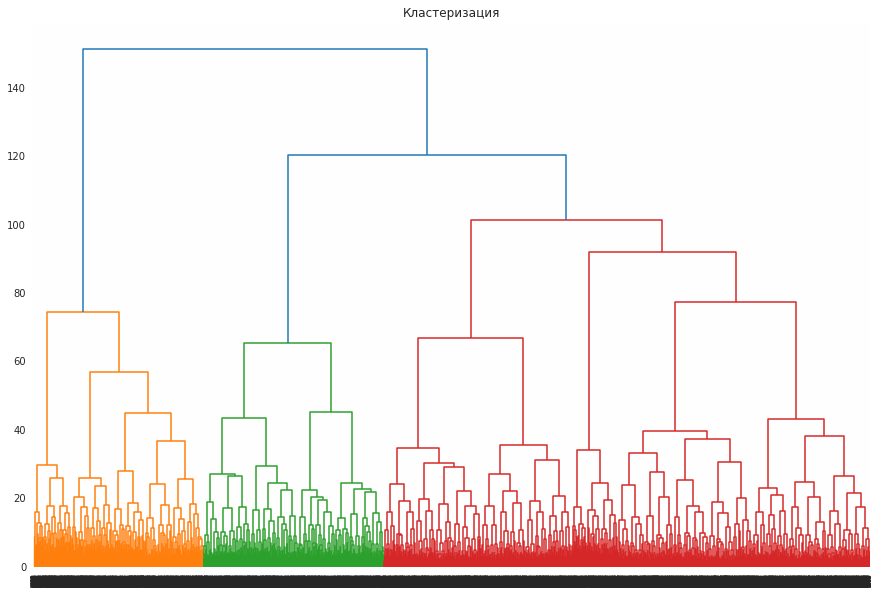

In [21]:
# Матрица расстояний
link = linkage(X_train_st, method = 'ward') 

# Построение дендрограммы 
plt.figure(figsize=(15, 10))  
dendrogram(link, orientation='top')
plt.title('Кластеризация')
plt.show() 

Исходя из разных цветов на дендрограмме, оптимальное количество кластеров - 3.

### Обучение модели
Для кластеризации воспользуемся алгоритмом KMean и на основании дендрограммы зададим оптимальное количество кластеров.

In [22]:
# Задаём число кластеров равное 3
kmean = KMeans(n_clusters=3, random_state=0) 
# Применяем алгоритм к данным и формируем вектор кластеров 
labels = kmean.fit_predict(X_train_st) 

### Оценка доли оттока в разных кластерах

In [23]:
# Сохранение меток кластера
bank_data_encode['cluster'] = labels
# Рассчет средних значений признаков в каждом кластере
bank_data_encode.groupby('cluster', as_index=False).mean().T

,0,1,2
cluster,0.0000,1.0000,2.0000
score,645.4512,648.8592,654.2135
city,0.9971,1.3300,1.3037
gender,0.4404,0.5678,0.5765
age,44.8691,35.4485,38.9640
objects,4.9358,5.1264,4.9572
products,1.4747,1.5551,1.5358
credit_card,0.6994,0.7063,0.7077
loyalty,0.3605,0.0000,1.0000
estimated_salary,101471.1460,100338.8466,99253.0618


In [24]:
# Количество клиентов каждой группы
bank_data_encode.groupby('cluster', as_index=False)['churn'].count().rename(columns={'churn': 'count'}).T

,0,1,2
cluster,0,1,2
count,2039,3545,4416


**Выводы**

Выделена группа клиентов подверженных оттоку, основным выделяющимся признаком является средний возраст - 45 лет. В отличии от 1 и 2 группы, во второй среднее значение пола клиента 0.4, что говорит, о большем количестве женщин в этой группе. Также в этой группе некоторая средняя активность в отличии от 2 - самой активной и 1 - с нулевой активностью. Значение города занижено, значит большее число клиентов из Ростова Великого

## Часть. Проверка статистических гипотез
### Проверка гипотезы различия дохода между теми клиентами, которые ушли и теми, которые остались

Рассмотрим следующую нулевую гипотезу - "Средний доход ушедших клиентов не отличается от дохода оставшихся". Сформулируем альтернативную гипотезу - "Средний доход ушедших клиентов отличается от дохода оставшихся". Для проверки гипотез создадим два датасета salary_0 и salary_1. Для проверки гипотез будет достаточно использовать p-value = 0.05.<br>
При этом данные должны удовлетворять следующим условиям:
1) Генеральные совокупности не должны зависеть друг от друга<br>
2) Выборочные средние должны быть нормально распределены<br>
3) Дисперсии рассматриваемых генеральных совокупностей должны быть равны<br>

In [25]:
# Датасет "Оставшиеся"
salary_0 = bank_data.query('churn == 0')['estimated_salary'].reset_index(drop=True)
# Датасет "Ушедшие"
salary_1 = bank_data.query('churn == 1')['estimated_salary'].reset_index(drop=True)

In [26]:
# Устанавка уровня значимости
alpha = .05
# Применение метод для сравнения средних
result = st.shapiro(salary_0)
# Вывод p-value
print(result.pvalue)
# Вывод по гипотезе
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: распределение не нормально")
else:
    print("Не отвергаем нулевую гипотезу: распределение нормально") 

print()

result = st.shapiro(salary_1)
# Вывод p-value
print(result.pvalue)
# Вывод по гипотезе
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: распределение не нормально")
else:
    print("Не отвергаем нулевую гипотезу: распределение нормально") 

3.8115318229635024e-43
Отвергаем нулевую гипотезу: распределение не нормально

4.594104044877579e-25
Отвергаем нулевую гипотезу: распределение не нормально


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [27]:
# Устанавка уровня значимости
alpha = .05
# Применение метод для сравнения средних
results = st.mannwhitneyu(salary_0, salary_1)
# Вывод p-value
print(result.pvalue)
# Вывод по гипотезе
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя") 

4.594104044877579e-25
Отвергаем нулевую гипотезу: разница статистически значима


Гипотезу удалось отвергнуть, значит доходы клиентов отличаются

### Проверка гипотезы различия баланса между теми клиентами, которые ушли и теми, которые остались

Рассмотрим следующую нулевую гипотезу - "Средний баланс ушедших клиентов не отличается от баланса оставшихся".Сформулируем альтернативную гипотезу - "Средний баланс ушедших клиентов отличается от баланса оставшихся". Для проверки гипотез создадим два датасета balance_0 и balance_1. Для проверки гипотез будет достаточно использовать p-value = 0.05.<br>
При этом данные должны удовлетворять следующим условиям:
1) Генеральные совокупности не должны зависеть друг от друга<br>
2) Выборочные средние должны быть нормально распределены<br>
3) Дисперсии рассматриваемых генеральных совокупностей должны быть равны<br>

In [28]:
# Датасет "Оставшиеся"
balance_0 = (bank_data.query('churn == 0')['balance'].dropna()).reset_index(drop=True)
# Датасет "Ушедшие"
balance_1 = (bank_data.query('churn == 1')['balance'].dropna()).reset_index(drop=True)

In [29]:
# Устанавка уровня значимости
alpha = .05
# Применение метод для сравнения средних
result = st.shapiro(balance_0)
# Вывод p-value
print(result.pvalue)
# Вывод по гипотезе
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: распределение не нормально")
else:
    print("Не отвергаем нулевую гипотезу: распределение нормально") 
    
print()

result = st.shapiro(balance_1)
# Вывод p-value
print(result.pvalue)
# Вывод по гипотезе
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: распределение не нормально")
else:
    print("Не отвергаем нулевую гипотезу: распределение нормально") 

0.8506813049316406
Не отвергаем нулевую гипотезу: распределение нормально

1.0646013848258917e-08
Отвергаем нулевую гипотезу: распределение не нормально


In [30]:
# Устанавка уровня значимости
alpha = .05
# Применение метод для сравнения средних
results = st.mannwhitneyu(balance_0, balance_1)
# Вывод p-value
print(result.pvalue)
# Вывод по гипотезе
if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя") 

1.0646013848258917e-08
Отвергаем нулевую гипотезу: разница статистически значима


Гипотезу удалось отвергнуть, значит баланс клиентов отличается

## Часть. Выводы
### Общий вывод по работе

По графикам можно сказать следующее:
1) Основная масса клиентов ушедших из банка это средняя и пожилая возрастные группы<br>
2) Ушедшие клиенты менее активно пользовались банковскими продуктами, в отличии от оставшихся<br>
3) Стоит обратить внимание на Росток Великий, т.к. отток клиентов в этом городе довольно высокий<br>
4) Обе гипотезы удалось опровергнуть, значит отток клиентов связан с их доходами или остатками на балансе<br>

По распределениям можно сказать следующее:
1) Клиенты с более плохим кредитным рейтингом уходят чаще<br>
2) Клиенты средней и пожилой группы уходят чаще<br>
3) В основном уходят клиенты, у которые относятся к средней балансной группе<br>
4) В Ярославле и Рыбинске больший отток клиентов, относящихся к низкой или высокой балансной группе, в Ростове Великом наоборот, больший отток средней балансной группы<br>
5) В Ростове Великом больший отток клиентов, чей доход ниже ~100 тыс., в Рыбинске чей доход больше ~100 тыс., в Ярославле чей доход выше ~150 тыс.<br>

На основе этого можно предположить, что молодые клиенты более активно пользуются банковскими продуктами, в отличии от старших клиентов. Возможно они больше заинтересованы в продуктах, предлагаемых банком, например, кредит, кредитная карта или вклад (здесь стоит вопрос с какой целью они решили воспользоваться услугами банка и какой услугой) или же от использования того или иного продукта они получат больше дополнительной выгоды ("плюшек"), в то время как старшим клиентам эти услуги могут не подходить, им непонятны условия использования или же нет "плюшек" от услуг банка. Также стоит обратить внимание, что в Ростове Великом довольно большой отток клиентов из средней и пожилой группы.

Возможно, для снижения оттока, стоит адаптировать некоторые продукты для клиентов средней и пожилой возрастных групп или же создать отдельные продукты ориентированные на эти группы, тоже стоит провести и для балансных групп.